<a href="https://colab.research.google.com/github/Tar-ive/protein-DL/blob/main/amino_acid_hack_nation_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
 import kagglehub

# Download latest version
path = kagglehub.dataset_download("googleai/pfam-seed-random-split")

print("Path to dataset files:", path)

100%|██████████| 493M/493M [00:22<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/googleai/pfam-seed-random-split/versions/1


In [3]:
import os

In [4]:
import os

# Check what's actually in the dataset directory
print("Contents of dataset directory:")
for item in os.listdir(path):
    print(f"  {item}")
    if os.path.isdir(os.path.join(path, item)):
        print(f"    Contents of {item}:")
        for subitem in os.listdir(os.path.join(path, item)):
            print(f"      {subitem}")

Contents of dataset directory:
  random_split
    Contents of random_split:
      random_split
      train
      test
      dev


In [10]:
inner_path = os.path.join(path, 'random_split', 'random_split')


In [12]:
def read_data_from_sharded_files(subdir_name, base_path):
    """Read all sharded data files from a subdirectory and concatenate them"""
    dir_path = os.path.join(base_path, subdir_name)
    data_frames = []

    # Get all files and sort them to maintain order
    files = sorted([f for f in os.listdir(dir_path) if f.startswith('data-')])

    for file in files:
        file_path = os.path.join(dir_path, file)
        try:
            # Try reading as parquet first (most likely format)
            df = pd.read_parquet(file_path)
            data_frames.append(df)
        except:
            try:
                # If parquet fails, try as CSV
                df = pd.read_csv(file_path)
                data_frames.append(df)
            except Exception as e:
                print(f"Could not read {file}: {e}")

    if data_frames:
        return pd.concat(data_frames, ignore_index=True)
    else:
        print(f"No readable files found in {dir_path}")
        return None

# Use the new function to load your data
train = read_data_from_sharded_files('train', inner_path)
dev = read_data_from_sharded_files('dev', inner_path)
test = read_data_from_sharded_files('test', inner_path)

print(f"Train shape: {train.shape if train is not None else 'Failed to load'}")
print(f"Dev shape: {dev.shape if dev is not None else 'Failed to load'}")
print(f"Test shape: {test.shape if test is not None else 'Failed to load'}")

Train shape: (1086741, 5)
Dev shape: (126171, 5)
Test shape: (126171, 5)


In [13]:
train.head()


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [14]:
train.shape

(1086741, 5)

In [15]:
dev.shape

(126171, 5)

In [16]:
test.shape

(126171, 5)

Looking at families in the training data

In [17]:
partitions = {'train': train, 'dev': dev, 'test': test}


In [18]:
def get_information(partitions):
    columns = ['partition', 'nb_samples', 'nb_families', 'min_samples_per_fam', 'max_samples_per_fam', 'mean_samples_per_fam']
    df_info = pd.DataFrame(columns=columns)
    for name, df in partitions.items():
        # Use pd.concat instead of df.append
        df_info = pd.concat([df_info, pd.DataFrame([{
            'partition': name,
            'nb_samples': len(df),
            'nb_families': df['family_accession'].unique().size,
            'max_samples_per_fam': df.groupby('family_accession').size().max(),
            'min_samples_per_fam': df.groupby('family_accession').size().min(),
            'mean_samples_per_fam': df.groupby('family_accession').size().mean(),
        }])], ignore_index=True)
    return df_info

get_information(partitions)

/tmp/ipython-input-710236014.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_info = pd.concat([df_info, pd.DataFrame([{


,partition,nb_samples,nb_families,min_samples_per_fam,max_samples_per_fam,mean_samples_per_fam
0,train,1086741,17929,1,3637,60.613587
1,dev,126171,13071,1,454,9.652743
2,test,126171,13071,1,454,9.652743


In [19]:
train_families = set(train['family_accession'].unique())
dev_families = set(dev['family_accession'].unique())
test_families = set(test['family_accession'].unique())
print('Are the families of the dev set and the test set the same ?', dev_families == test_families)

common_families = train_families & dev_families & test_families # Take the intersection with the '&' operator
print('Number of common families in all sets : ', len(common_families))

Are the families of the dev set and the test set the same ? True
Number of common families in all sets :  13071


Excluding the families that are only in train but not in dev and test


In [20]:
train = train[train['family_accession'].isin(common_families)]
partitions['train'] = train

print('Updated info on the datasets')
get_information(partitions)

Updated info on the datasets


/tmp/ipython-input-710236014.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_info = pd.concat([df_info, pd.DataFrame([{


,partition,nb_samples,nb_families,min_samples_per_fam,max_samples_per_fam,mean_samples_per_fam
0,train,1064950,13071,8,3637,81.474256
1,dev,126171,13071,1,454,9.652743
2,test,126171,13071,1,454,9.652743


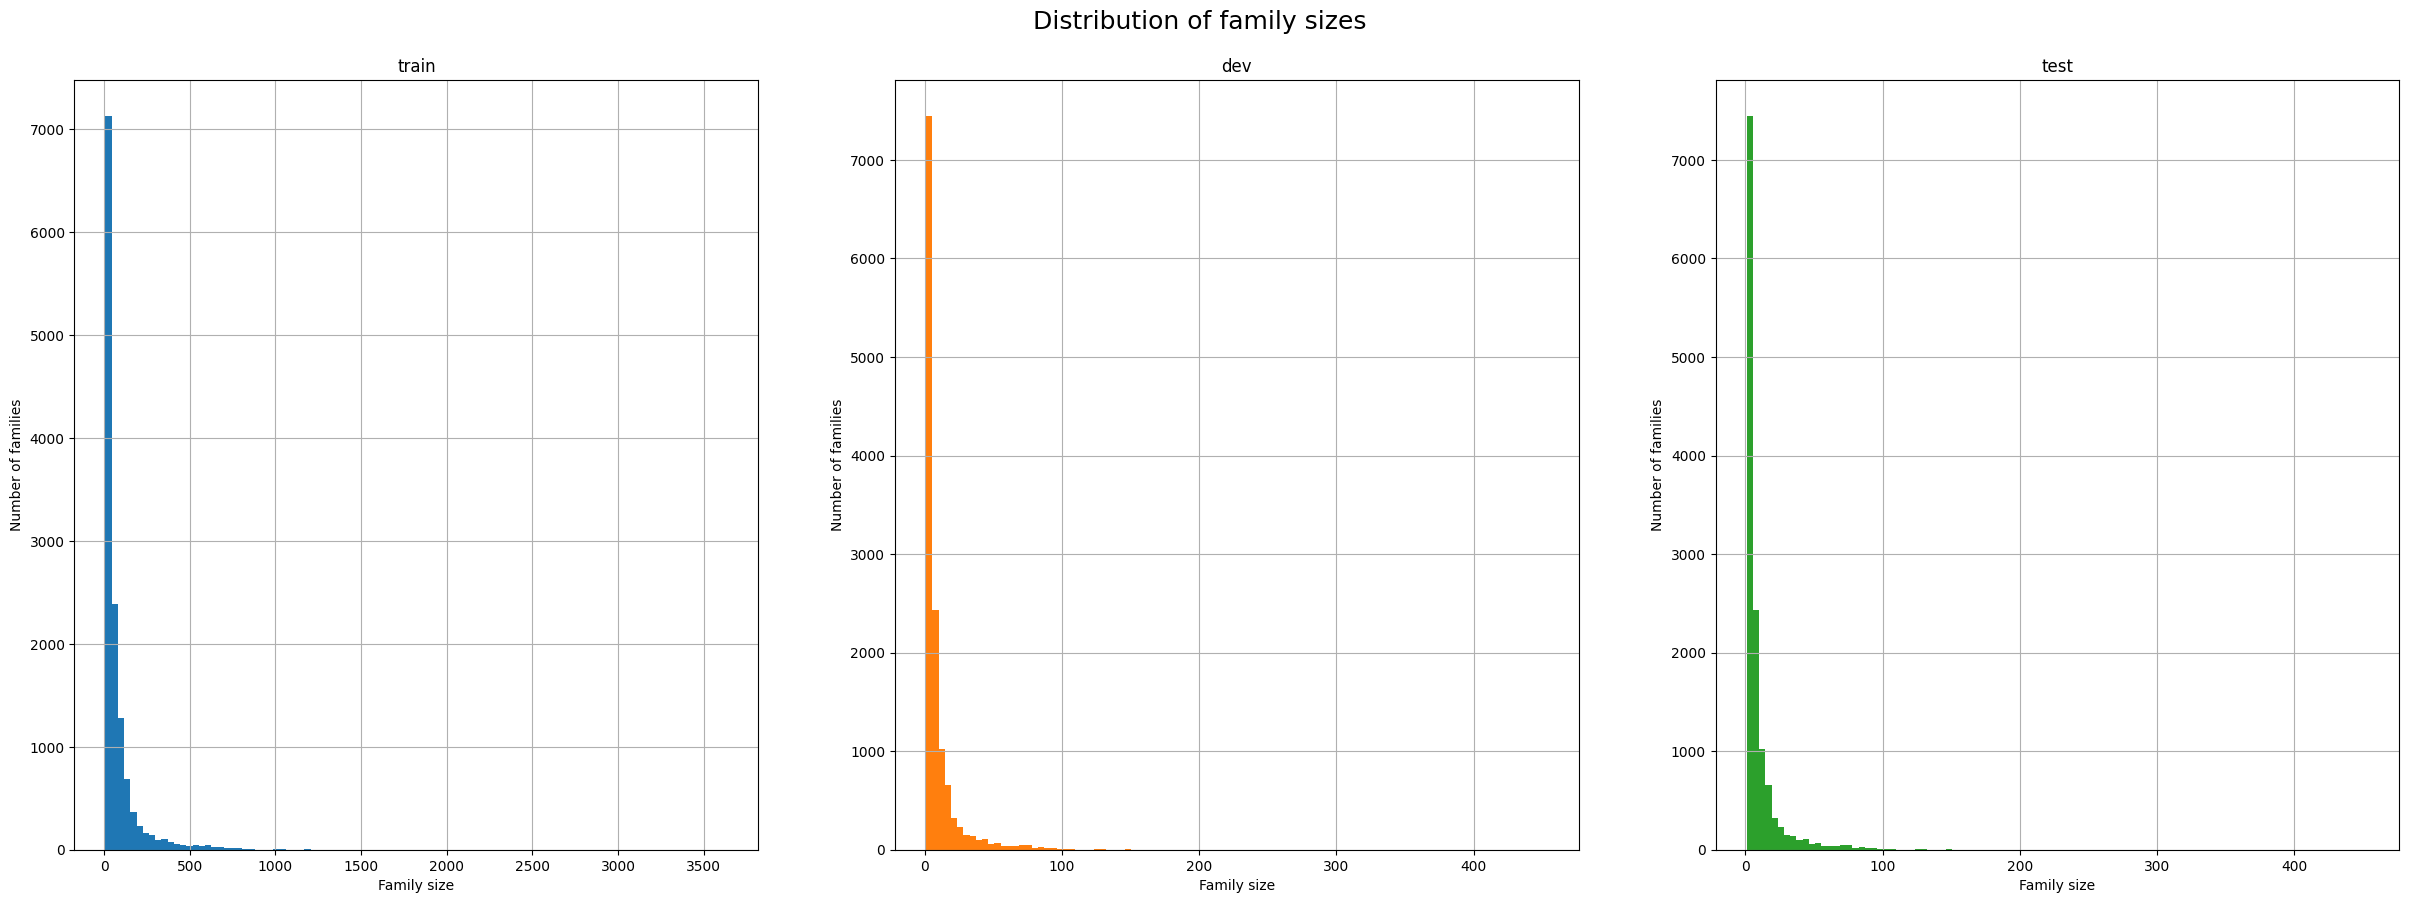

In [21]:
plt.figure(figsize = (30, 10))
plt.suptitle('Distribution of family sizes', fontsize=18, y=0.95)
colors = ['tab:blue', 'tab:orange', 'tab:green']

for n, (name, df) in enumerate(partitions.items()):
    # Create the subpot
    ax = plt.subplot(1, 3, n + 1)
    ax.set_title(name)
    ax.set_xlabel("Family size")
    ax.set_ylabel("Number of families")

    # Plot data
    df.groupby('family_id').size().hist(bins=100, ax=ax, color=colors[n])


# Finetuning Environemnt Setup

In [22]:
!pip install transformers[torch] datasets evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import matplotlib.pyplot as plt

In [24]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU name: NVIDIA A100-SXM4-40GB


In [25]:
# You already have this data loaded, so let's just verify it
print("Data shapes:")
print(f"Train: {train.shape}")
print(f"Dev: {dev.shape}")
print(f"Test: {test.shape}")

# Check the column names
print(f"\nTrain columns: {train.columns.tolist()}")

Data shapes:
Train: (1064950, 5)
Dev: (126171, 5)
Test: (126171, 5)

Train columns: ['family_id', 'sequence_name', 'family_accession', 'aligned_sequence', 'sequence']


In [26]:
# Combine all datasets for sampling strategy
all_data = pd.concat([train, dev, test], ignore_index=True)
print(f"Total dataset size: {all_data.shape}")

# Explore the family distribution
family_counts = all_data['family_accession'].value_counts()
print(f"Number of unique families: {len(family_counts)}")
print(f"Most common families:")
print(family_counts.head(10))

Total dataset size: (1317292, 5)
Number of unique families: 13071
Most common families:
family_accession
PF13649.6     4545
PF00560.33    2407
PF13508.7     2199
PF06580.13    1921
PF02397.16    1908
PF00677.17    1878
PF01035.20    1681
PF02417.15    1579
PF13472.6     1564
PF00684.19    1512
Name: count, dtype: int64


To speed things up, I selected a smaller, representative sample. A good starting point was to take the top 1,000 most frequent families and then take up to 100 examples from each of those families. This gives me a balanced and manageable dataset of around 100,000 sequences

In [27]:
# Get top 1000 most frequent families
top_1000_families = family_counts.head(1000).index.tolist()
print(f"Selected top {len(top_1000_families)} families")

# Filter data to only include these families
filtered_data = all_data[all_data['family_accession'].isin(top_1000_families)]
print(f"Filtered dataset size: {filtered_data.shape}")

Selected top 1000 families
Filtered dataset size: (548249, 5)


In [28]:
# Sample up to 100 sequences per family for balanced training
sampled_data = []

for family in top_1000_families:
    family_data = filtered_data[filtered_data['family_accession'] == family]
    # Sample up to 100, or all if less than 100
    sample_size = min(100, len(family_data))
    sampled_family = family_data.sample(n=sample_size, random_state=42)
    sampled_data.append(sampled_family)

# Combine all sampled data
balanced_dataset = pd.concat(sampled_data, ignore_index=True)
print(f"Balanced dataset size: {balanced_dataset.shape}")
print(f"Average samples per family: {len(balanced_dataset) / len(top_1000_families):.1f}")

Balanced dataset size: (100000, 5)
Average samples per family: 100.0


In [29]:
# Extract sequences and labels
sequences = balanced_dataset['sequence'].tolist()
family_labels = balanced_dataset['family_accession'].tolist()

print(f"Number of sequences: {len(sequences)}")
print(f"Number of labels: {len(family_labels)}")
print(f"Example sequence length: {len(sequences[0])}")
print(f"Example sequence: {sequences[0][:50]}...")

Number of sequences: 100000
Number of labels: 100000
Example sequence length: 98
Example sequence: ALDIGAGTADLALLIEPKMGREGHVIASDLNHAMLAEGLRKVTGRGLRDR...


In [30]:
# Convert family accession strings to numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(family_labels)

print(f"Label encoding complete!")
print(f"Number of unique labels: {len(label_encoder.classes_)}")
print(f"Example mappings:")
for i in range(5):
    print(f"  {family_labels[i]} -> {encoded_labels[i]}")

Label encoding complete!
Number of unique labels: 1000
Example mappings:
  PF13649.6 -> 873
  PF13649.6 -> 873
  PF13649.6 -> 873
  PF13649.6 -> 873
  PF13649.6 -> 873


In [31]:
# Load the ESM-2 tokenizer
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print(f"Tokenizer loaded: {model_checkpoint}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenizer loaded: facebook/esm2_t12_35M_UR50D
Vocabulary size: 33


In [32]:
# Tokenize all sequences (this might take a few minutes)
print("Tokenizing sequences...")
tokenized_sequences = tokenizer(
    sequences,
    truncation=True,
    padding=True,
    max_length=512,  # Adjust if needed based on your sequence lengths
    return_tensors="pt"
)

print("Tokenization complete!")
print(f"Input shape: {tokenized_sequences['input_ids'].shape}")

Tokenizing sequences...
Tokenization complete!
Input shape: torch.Size([100000, 512])


In [33]:
# Split into train and test sets (80/20 split)
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    sequences,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels  # Ensure balanced split across families
)

print(f"Training set size: {len(train_sequences)}")
print(f"Test set size: {len(test_sequences)}")

Training set size: 80000
Test set size: 20000


In [34]:
# Tokenize the split data
train_tokenized = tokenizer(
    train_sequences,
    truncation=True,
    padding=True,
    max_length=512
)

test_tokenized = tokenizer(
    test_sequences,
    truncation=True,
    padding=True,
    max_length=512
)

print("Split data tokenized!")

Split data tokenized!


In [35]:
# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# Add labels
train_dataset = train_dataset.add_column("labels", train_labels.tolist())
test_dataset = test_dataset.add_column("labels", test_labels.tolist())

print("Final datasets created!")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")
print(f"Number of labels: {len(label_encoder.classes_)}")

Final datasets created!
Train dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 80000
})
Test dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20000
})
Number of labels: 1000


In [36]:
# Load ESM-2 model for sequence classification
num_labels = 1000  # Your number of protein families
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)

print(f"Model loaded with {num_labels} output classes")
print(f"Model size: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 1000 output classes
Model size: 34.0M parameters


In [37]:
# Login to Hugging Face to enable automatic upload
from huggingface_hub import notebook_login

notebook_login()

In [38]:
from transformers import TrainingArguments

# Create a descriptive model name
model_name = model_checkpoint.split("/")[-1]
output_dir = f"{model_name}-finetuned-pfam-1k"

args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Adjust if you get memory errors
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,  # This will auto-upload to HF!
    hub_model_id=f"Tarive/{output_dir}",  # Replace with your HF username
    hub_strategy="every_save",
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
)

print(f"Training will save to: {output_dir}")
print(f"Model will be uploaded to: Tarive/{output_dir}")

Training will save to: esm2_t12_35M_UR50D-finetuned-pfam-1k
Model will be uploaded to: Tarive/esm2_t12_35M_UR50D-finetuned-pfam-1k


In [39]:
from evaluate import load
import numpy as np

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

print("Evaluation metrics defined!")

Evaluation metrics defined!


In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer created! Ready to start training...")

/tmp/ipython-input-3129623117.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer created! Ready to start training...


In [41]:
# This is the big moment - start training!
print("🚀 Starting training...")
print("This will take approximately 15-30 minutes on T4 GPU")
print("You'll see progress bars and accuracy metrics")

trainer.train()

print("✅ Training complete!")

🚀 Starting training...
This will take approximately 15-30 minutes on T4 GPU
You'll see progress bars and accuracy metrics


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tarive22 (tarive22-shivoham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,3.202500,3.167127,0.850350
2,1.289000,1.197241,0.962050
3,0.753500,0.818404,0.979000


✅ Training complete!


In [42]:
import pickle

# Save the label encoder to a file named 'label_encoder.pkl'
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("✅ LabelEncoder saved to label_encoder.pkl")

✅ LabelEncoder saved to label_encoder.pkl
